<a href="https://colab.research.google.com/github/suvashsumon/My_Thesis_Experiments/blob/main/Experiment_5_CNN_With_Extracted_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install libemg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 4.8 MB/s eta 0:00:00
  Created wheel for libemg: filename=libemg-0.0.1-py3-none-any.whl size=70338 sha256=a3e59af62a7b99ac204abbea0ae0f75a8c3de9138c01982c0cfc7710c009fbaa
  Stored in directory: /root/.cache/pip/wheels/52/29/b7/c395fce515bf8995f6c17ffa968697b66fd497a4c6a1c04481
Successfully built libemg


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scipyio
import seaborn as sns
import pandas as pd
from libemg.feature_extractor import FeatureExtractor
from libemg.utils import get_windows
from google.colab import drive
import os
from sklearn.preprocessing import MinMaxScaler

**Reading Dataset**

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
gestures_label = {
	 'Thumb_UP' : 0,
	 'Index' : 1,
	 'Right_Angle' : 2,
	 'Peace' : 3,
	 'Index_Little' : 4,
	 'Thumb_Little' : 5,
	 'Hand_Close' : 6,
	 'Hand_Open' : 7,
	 'Wrist_Extension' : 8,
	 'Wrist_Flexion' : 9,
	 'Ulner_Deviation' : 10,
	 'Radial_Deviation' : 11
}

gestures = ['Thumb_UP', 'Index_Little', 'Right_Angle', 'Peace', 'Index', 'Thumb_Little', 'Hand_Close', 'Hand_Open',
	 'Wrist_Extension', 'Wrist_Flexion', 'Ulner_Deviation', 'Radial_Deviation'
]

In [6]:
persons = ["Arifa", "Arnob", "Ashis", "Bayezid", "Bushra", "Choity_new", "Eftekhar",
           "Fahim", "Humaid", "Humayun", "Johir", "Joy", "Mamun", "Noman", "Piyus", "Sazzad",
           "Shafi", "Shourav", "Tamim", "Wadud"]

In [7]:
def get_gesture_label(gesture):
  return gestures_label [gesture];

In [8]:
def scaleTo01(matrix):
  scaler = MinMaxScaler()
  scaler.fit(matrix)
  scaled_matrix = scaler.transform(matrix)
  return scaled_matrix

In [44]:
def feature_extraction(channelvalues, gesture, feature_list):
  # creating windows
  windows = get_windows(channelvalues, 150, 150)
  # extract feature
  fe = FeatureExtractor()
  features = fe.extract_features(feature_list, windows)
  # print(features.keys())
  # creating feature matrixs
  extracted_feature_array = []
  extracted_gesture_array = []
  for i in range(windows.shape[0]):
    features_matrix = []
    for abb in feature_list:
      features_matrix.append(features[abb][i])
    #print(features['MAV'].shape)
    #print(features['AR'].shape)
    #features_matrix = (features_matrix-np.min(features_matrix))/(np.max(features_matrix)-np.min(features_matrix))
    features_matrix = scaleTo01(features_matrix)
    extracted_feature_array.append(features_matrix)
    extracted_gesture_array.append(get_gesture_label(gesture))
    #print(len(extracted_feature_array))
  return extracted_feature_array, extracted_gesture_array

In [45]:
def get_processed_data(matfilepath, gesture):
  # read mat file
  matdata = scipyio.loadmat(matfilepath)
  # transpose the matrix
  values = np.transpose(matdata['value'])
  # remove the first 3000 values
  values = values[3000:]
  return feature_extraction(values, gesture, feature_list)


In [70]:
def get_input(persons, gestures, feature_list, orientaion):
  input_array = []
  input_gest = []
  for person in persons:
    for gest in gestures:
      for i in range(5):
        matfilepath = "gdrive/My Drive/Forearm Invariant Data/"+person+"/"+orientaion+"/"+gest+"-"+str(i+1)+".mat"
        #print(matfilepath)
        processed_matrix, gesture_array = get_processed_data(matfilepath, gest)
        gest_label = get_gesture_label(gest)
        input_array = input_array + processed_matrix
        input_gest = input_gest + gesture_array
  return input_array, input_gest

In [47]:
feature_list = [
    'MAV',
    'SSC',
    'ZC',
    'WL',
    'LS',
    'MFL',
    'MSR',
    'WAMP',
    'RMS',
    'IAV',
    'DASDV',
    'VAR',
    'M0',
    'M2',
    'M4',
    'SPARSI',
    'IRF',
    # 'WLR',
    'LD',
]

In [71]:
X, Y = get_input(persons, gestures, feature_list, 'Rest')

In [72]:
len(X), len(Y)

(39600, 39600)

In [73]:
#
df = pd.DataFrame(X[0])
index = pd.Index(feature_list)
df = df.set_index(index)
df

,0,1,2,3,4,5,6,7
MAV,0.008001,0.008084,0.007365,0.007530,0.007505,0.007738,0.007403,0.007212
SSC,0.818896,0.847997,0.721417,0.651849,0.637681,0.696970,0.597122,0.814754
ZC,0.133851,0.255983,0.285684,0.244438,0.253623,0.272727,0.251797,0.384982
WL,0.024668,0.023681,0.055547,0.026569,0.038277,0.027514,0.033890,0.028643
LS,0.007963,0.008053,0.007291,0.007489,0.007439,0.007690,0.007346,0.007171
MFL,0.010458,0.010321,0.013040,0.010458,0.011824,0.010759,0.011290,0.010517
MSR,0.008520,0.008568,0.007978,0.008051,0.008113,0.008292,0.007982,0.007742
WAMP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
RMS,0.008076,0.008113,0.007451,0.007565,0.007600,0.007777,0.007487,0.007245
IAV,0.028090,0.023915,0.046653,0.026931,0.046132,0.031916,0.038773,0.027051


In [74]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((39600, 18, 8), (39600,))

**Model Building**

In [75]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    X,Y,
    test_size = .2, shuffle=True, random_state=0
)

In [76]:
len(x_train), len(y_train)

(31680, 31680)

In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization

# Define the input shape
input_shape = x_train[0].shape

# Create a Sequential model
model = Sequential()

# Add a Conv1D layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

# Add a MaxPooling1D layer (optional)
model.add(MaxPooling1D(pool_size=2))

# Flatten the output before feeding it to a Dense layer
model.add(Flatten())

# Add a Dense layer
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.2))

model.add(BatchNormalization()),

# Add a Dense layer
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.2))

# Add a Dense layer
model.add(Dense(16, activation='relu'))
#model.add(Dropout(0.2))

# Output layer for classification (adjust units according to the number of classes)
# Assuming classes are integers starting from 0
model.add(Dense(12, activation='softmax'))

# Compile the model
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 16, 32)            800       
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 8, 32)             0         
 g1D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 32)               

In [79]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [80]:
# Fit the model with training data
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/100
990/990 [==============================] - 5s 4ms/step - loss: 1.9516 - accuracy: 0.3292 - val_loss: 1.7464 - val_accuracy: 0.3734
Epoch 2/100
990/990 [==============================] - 4s 4ms/step - loss: 1.3731 - accuracy: 0.5169 - val_loss: 1.4617 - val_accuracy: 0.4931
Epoch 3/100
990/990 [==============================] - 3s 3ms/step - loss: 1.1726 - accuracy: 0.5765 - val_loss: 1.2135 - val_accuracy: 0.5506
Epoch 4/100
990/990 [==============================] - 4s 4ms/step - loss: 1.0625 - accuracy: 0.6094 - val_loss: 1.4315 - val_accuracy: 0.4806
Epoch 5/100
990/990 [==============================] - 3s 4ms/step - loss: 0.9793 - accuracy: 0.6403 - val_loss: 1.0665 - val_accuracy: 0.6122
Epoch 6/100
990/990 [==============================] - 3s 3ms/step - loss: 0.9231 - accuracy: 0.6601 - val_loss: 1.3351 - val_accuracy: 0.5476
Epoch 7/100
990/990 [==============================] - 3s 3ms/step - loss: 0.8559 - accuracy: 0.6835 - val_loss: 1.2761 - val_accuracy: 0.5519

**Classification Report**

In [81]:
rest_results = model.evaluate(x_test, y_test, batch_size=32)
print(rest_results)

248/248 [==============================] - 1s 2ms/step - loss: 0.9484 - accuracy: 0.6564
[0.9484062194824219, 0.6564394235610962]


In [83]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = model.predict(x_test)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report : ")
print(classification_report(y_test, y_pred_classes))

248/248 [==============================] - 1s 3ms/step
Classification Report : 
              precision    recall  f1-score   support

           0       0.63      0.37      0.47       646
           1       0.53      0.21      0.30       648
           2       0.60      0.35      0.44       675
           3       0.42      0.82      0.56       674
           4       0.66      0.47      0.55       676
           5       0.57      0.86      0.69       652
           6       0.63      0.71      0.66       693
           7       0.68      0.73      0.70       634
           8       0.73      0.96      0.83       687
           9       0.99      0.68      0.80       633
          10       0.89      0.83      0.86       674
          11       0.80      0.89      0.84       628

    accuracy                           0.66      7920
   macro avg       0.68      0.66      0.64      7920
weighted avg       0.68      0.66      0.64      7920



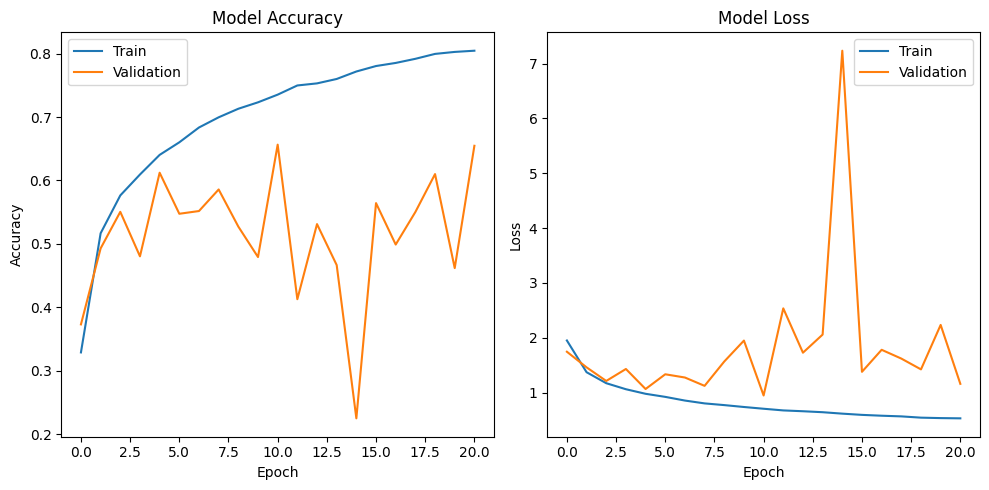

In [84]:
# Plotting model accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    #plt.ylim(0, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    #plt.ylim(0, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function to plot the history
plot_history(history)

**Validation with Pronation Data**

In [87]:
x_pronation, y_pronation = get_input(persons, gestures, feature_list, 'Pronation')
x_pronation = np.array(x_pronation)
y_pronation = np.array(y_pronation)

In [88]:
pronation_results = model.evaluate(x_pronation, y_pronation, batch_size=32)
print(pronation_results)

1238/1238 [==============================] - 4s 3ms/step - loss: 1.3833 - accuracy: 0.5509
[1.3833104372024536, 0.5508838295936584]


**Validation with Supination Data**

In [90]:
x_supination, y_supination = get_input(persons, gestures, feature_list, "Supination")
x_supination = np.array(x_supination)
y_supination = np.array(y_supination)

In [91]:
supination_results = model.evaluate(x_supination, y_supination, batch_size=32)
print(supination_results)

1238/1238 [==============================] - 3s 2ms/step - loss: 1.7387 - accuracy: 0.4818
[1.7387011051177979, 0.4817676842212677]


**Final Report**

In [92]:
print(f"Rest -> {rest_results[1]*100}%")
print(f"Pronation -> {pronation_results[1]*100}%")
print(f"Supination -> {supination_results[1]*100}%")

Rest -> 65.64394235610962%
Pronation -> 55.088382959365845%
Supination -> 48.17676842212677%
